# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Predicting house prices: a regression V2

</font>
</div>

# Theoretical recall: regression vs. logisitc-regression

<div class="alert alert-block alert-info">
<font color=black><br>

- Don’t confuse regression and the algorithm logistic regression. 
- Confusingly, logistic regression isn’t a regression algorithm—it’s a classification algorithm.

<br></font>
</div>

# Import libraries/modules

In [28]:
import numpy as np
from keras.datasets import boston_housing
from keras import models
from keras import layers
import matplotlib.pyplot as plt

# Load the datatest

<div class="alert alert-block alert-info">
<font color=black><br>

- Prices of homes in Boston in the mid-1970s.
- It has relatively few data points: only 506, split between 404 training samples and 102 test samples. 
- Each feature in the input data (for example, the crime rate) has a **different scale**.
- For instance, some values are pro- portions, which take values between 0 and 1; others take values between 1 and 12, oth- ers between 0 and 100, and so on.
- There are 13 features.
- The targets are the median values of owner-occupied homes, in thousands of dollars.

<br></font>
</div>

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

# Data pre-processing

<div class="alert alert-block alert-info">
<font color=black><br>

- It would be problematic to feed into a neural network values that all take wildly different ranges. 
- The current best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix).
- You subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.
- You should **never** use in your workflow any quantity computed on the test data, even for something as simple as data normalization.

<br></font>
</div>

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

# Building the network

<div class="alert alert-block alert-info">
<font color=black><br>

- Because so **few** samples are available, you’ll use a very small network with two hidden layers, each with 64 units. 
- In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.
- Because you’ll need to instantiate the same model multiple times, you use a function to construct it.
- The network ends with a single unit and **no activation** (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range the out- put can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.
- The **metrics** attribute in the compile part means you are monitoring that value.

<br></font>
</div>

In [8]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# Validating via k-fold

<div class="alert alert-block alert-info">
<font color=black><br>

- The validation set is already very small. Splitting again in order to get a validation test woudl reduce the set too muhc with less than 100 ppoint.
- The best practice in such situations is to use K-fold cross-validation.
- It consists of splitting the available data into K partitions (typically K = 4 or 5)
- Instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. 
- The validation score for the model used is then the average of the K validation scores obtained.

<br></font>
</div>

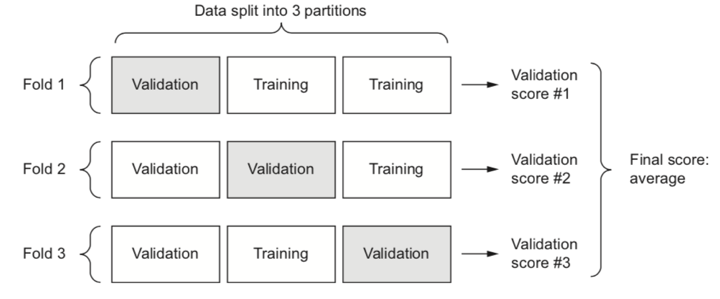

In [17]:
k=4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

In [18]:
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]], axis=0)

    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [19]:
all_scores

[2.0275914669036865, 2.5553104877471924, 2.7240917682647705, 2.412973403930664]

In [20]:
np.mean(all_scores)

2.4299917817115784

<div class="alert alert-block alert-info">
<font color=black><br>

- The average is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation. 
- Nevertheless we are still off by thousands and we'll try to run the newtwork for longer.
- To keep a record of how well the model does at each epoch, you’ll modify the training loop to save the per- epoch validation score log.

<br></font>
</div>

In [23]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [30]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]], axis=0)

    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

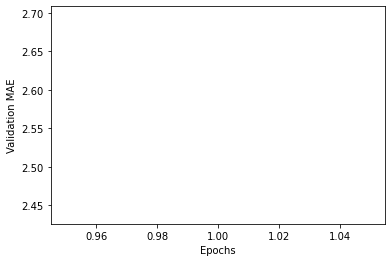

In [32]:
# We just excluded the first 10 data points to ease the visualisation process
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Training the final model

<div class="alert alert-block alert-info">
<font color=black><br>

- According to the graph start to overfit after 80 epochs.
- This is a valuable piece of information we can use to train our final model.
- You'll see we are stil off by 2.587k

<br></font>
</div>

In [33]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 15.2130 - mae: 2.5876


In [34]:
test_mae_score

2.587574005126953

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://github.com/fchollet/deep-learning-with-python-notebooks
- Chollet, Francois. Deep learning with Python. Vol. 361. New York: Manning, 2018

</font>
</div>